In [7]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

from collections import OrderedDict


In [8]:
import shephard
from shephard.apis import uniprot, fasta
from shephard.interfaces import si_protein_attributes, si_domains
from sparrow import Protein


### How to use
The cell below must be updated to point a local directory where the [SHEPHARD data from Ginell et al. has been downloaded from](https://github.com/holehouse-lab/supportingdata/tree/master/2022/ginell_2022/shprd_data)

In [9]:
# link to the directory at https://github.com/holehouse-lab/supportingdata/tree/master/2022/ginell_2022/shprd_data
shephard_data_dir = '<base_dir> 2022/ginell_2022/shprd_data/'

In [10]:
#             
datasets = {'arabidopsis':[],
            'e_coli_wisniewski': [],
            'pombe':[],
            'yeast_ghaemmaghami':[],
            'human':[],
            'xenopus':[]}
           
            

datasets['arabidopsis'].append(f'{shephard_data_dir}/arabidopsis/arabidopsis_clean.fasta')
datasets['arabidopsis'].append(f'{shephard_data_dir}/arabidopsis/shprd_arabidopsis_copynumber_bassal_abundance_leaf_time_all_v2.tsv')
datasets['arabidopsis'].append(f'{shephard_data_dir}/arabidopsis/shprd_domains_idrs_arabidopsis.tsv')

datasets['e_coli_wisniewski'].append(f'{shephard_data_dir}/e_coli/ecoli_clean.fasta')
datasets['e_coli_wisniewski'].append(f'{shephard_data_dir}/e_coli/shprd_ecoli_copynumber_wisniewski.tsv')
datasets['e_coli_wisniewski'].append(f'{shephard_data_dir}/e_coli/shprd_domains_idrs_ecoli.tsv')

datasets['pombe'].append(f'{shephard_data_dir}/pombe/pombe_clean.fasta')
datasets['pombe'].append(f'{shephard_data_dir}/pombe/shprd_pombe_copynumber.tsv')
datasets['pombe'].append(f'{shephard_data_dir}/pombe/shprd_domains_idrs_pombe.tsv')

datasets['yeast_ghaemmaghami'].append(f'{shephard_data_dir}/yeast/s_cerevisiae_clean.fasta')
datasets['yeast_ghaemmaghami'].append(f'{shephard_data_dir}/yeast/shprd_yeast_copynumber_ghaemmaghami.tsv')
datasets['yeast_ghaemmaghami'].append(f'{shephard_data_dir}/yeast/shprd_domains_idrs_s_cerevisiae.tsv')

datasets['human'].append(f'{shephard_data_dir}/human_proteome_validated.fasta')
datasets['human'].append(f'{shephard_data_dir}/shprd_protein_attributes_concentrations.tsv')
datasets['human'].append(f'{shephard_data_dir}/shprd_domains_idrs_metapredict_v2.tsv')

datasets['xenopus'].append(f'{shephard_data_dir}/xenopus/xenopus_clean.fasta')
datasets['xenopus'].append(f'{shephard_data_dir}/xenopus/shprd_xenopus_copynumber.tsv')
datasets['xenopus'].append(f'{shephard_data_dir}/xenopus/shprd_domains_idrs_xenopus.tsv')



all_proteomes = {}
for i in datasets:
    print(f'Parsing data for {i}')
    tmp = uniprot.uniprot_fasta_to_proteome(datasets[i][0])
    si_protein_attributes.add_protein_attributes_from_file(tmp, datasets[i][1])
    si_domains.add_domains_from_file(tmp, datasets[i][2])
    
    # remove proteins missing the copy_number annotation, and for those where 
    # present cast into an Int
    remove = []
    for protein in tmp:
        if 'copy_number' not in protein.attributes:
            remove.append(protein.unique_ID)
        else:
            
            # note this just cast the string to a float and then rounds to nearest integer...
            protein.add_attribute('copy_number', int(np.rint(float(protein.attribute('copy_number')))), safe=False)
    tmp.remove_proteins(remove)
    
    # associate the Proteome with the dictionary
    all_proteomes[i] = tmp
    
    


Parsing data for arabidopsis
Parsing data for e_coli_wisniewski
Parsing data for pombe
Parsing data for yeast_ghaemmaghami
Parsing data for human
Parsing data for xenopus


In [5]:
def get_ncpr_vs_copynumber(proteome):
    """
    Function that takes in a SHEPHARD Proteome object and returns a set 
    of data for working with copy number and protein net charge.
    
    Parameters
    --------------
    proteome : shephard.proteome.Proteome
        Returns a SHEPHARD proteome object
        
    Returns
    -------------
    tuple
    
        [0] - list - copy number of proteins (unordered but consistent with NCPR order)
        [1] - ncpr - net charge per residue  (unordered but consistent with cn order)
        [2] - sort_on_cn_np - np.array of size 3 x n where 
              col1 = copy number
              col2 = NCPR
              col3 = sequence length
        [3] - sort_on_cn - dictionary that is ordered by copy number and keys are UniProt accessions
    
    
    """
    
    # copy number list
    cn = []
    
    # net charge per residue (NCPR) list
    ncpr = []
    
    # organizing dictionary
    return_dict = {}
    
    
    # for each protein the proteome...
    for p in proteome:        
        
        # update the cn and ncpr lists
        cn.append(p.attribute('copy_number'))
        ncpr.append(Protein(p.sequence).NCPR)
        
        
        # create an entry into the return_dict indexed by the unique accession ID where some key info
        # is easily accessilble
        return_dict[p.unique_ID] = [p.attribute('copy_number'), Protein(p.sequence).NCPR, len(p.sequence)]
            
            
    # build an ordered dictionary where the keys are sorted by the protein copy number
    sort_on_cn = OrderedDict(sorted(return_dict.items(), key=lambda item: item[1][0], reverse=True) )
    
    # get a 3xn np.array where col1 = copy number, col2 = NCPR and col3 = sequence length
    sort_on_cn_np = np.array(list(sort_on_cn.values()))
    
            
    return [cn, ncpr, sort_on_cn_np, sort_on_cn]


def write_protein_info_to_csv(filename, list_of_proteins, annot):
    """
    Helper function to write out protein info for SI.
    
    Parameters
    --------------
    filename : str
        Name of the file to be writtem
        
    list_of_proteins : list
        List of proteins which will be cycled write and written out
        
    annot : dict
        A dictionary of annotations, where keys are the uniprot IDs 
        associated with the list_of_proteins, and the values are 
        strings of arbitrary values.
        
    Returns
    --------------
    None
        No returns, but this function writes a csv file with the 
        format 
                
        uniprot_id, name, annotation, FCR, NCR, copy_number, sequence
        
        This output was converted into an .xlsx file for the Boeynaems
        et al. 2023 paper.    
    
    """
    
    with open(filename,'w') as fh:
        
        # hardcoded header line 
        header = f'#UniProt ID, Name, Annotation, FCR, NCPR, copy number, sequence\n'
        
        # write the header line
        fh.write(header)
                
        # cycle over 
        for idx, p in enumerate(list_of_proteins):
            
            sp = Protein(p.sequence)
            
            outstring = f"{p.unique_ID}, {p.name.replace(',','')}, {annot[idx]}, {sp.FCR}, {sp.NCPR}, {p.attribute('copy_number')}, {p.sequence}\n"
            fh.write(outstring)
            

    


On arabidopsis
Index used: 2950/12857
Positive fraction: 0.091
Negative fraction: 0.062
Positive count: 269
Negative count: 184
Fraction ribosomal proteins: 0.6097
Fraction histone proteins  : 0.0446
On pombe
Index used: 821/3173
Positive fraction: 0.128
Negative fraction: 0.079
Positive count: 105
Negative count: 65
Fraction ribosomal proteins: 0.6762
Fraction histone proteins  : 0.0381
On yeast_ghaemmaghami
Index used: 767/3855
Positive fraction: 0.116
Negative fraction: 0.143
Positive count: 89
Negative count: 110
Fraction ribosomal proteins: 0.8315
Fraction histone proteins  : 0.0449
On e_coli_wisniewski
Index used: 368/2229
Positive fraction: 0.117
Negative fraction: 0.084
Positive count: 43
Negative count: 31
Fraction ribosomal proteins: 0.9535
Fraction histone proteins  : 0.0
On xenopus
Index used: 66/2459
Positive fraction: 0.379
Negative fraction: 0.03
Positive count: 25
Negative count: 2
Fraction ribosomal proteins: 0.92
Fraction histone proteins  : 0.0
On human
Index used: 1

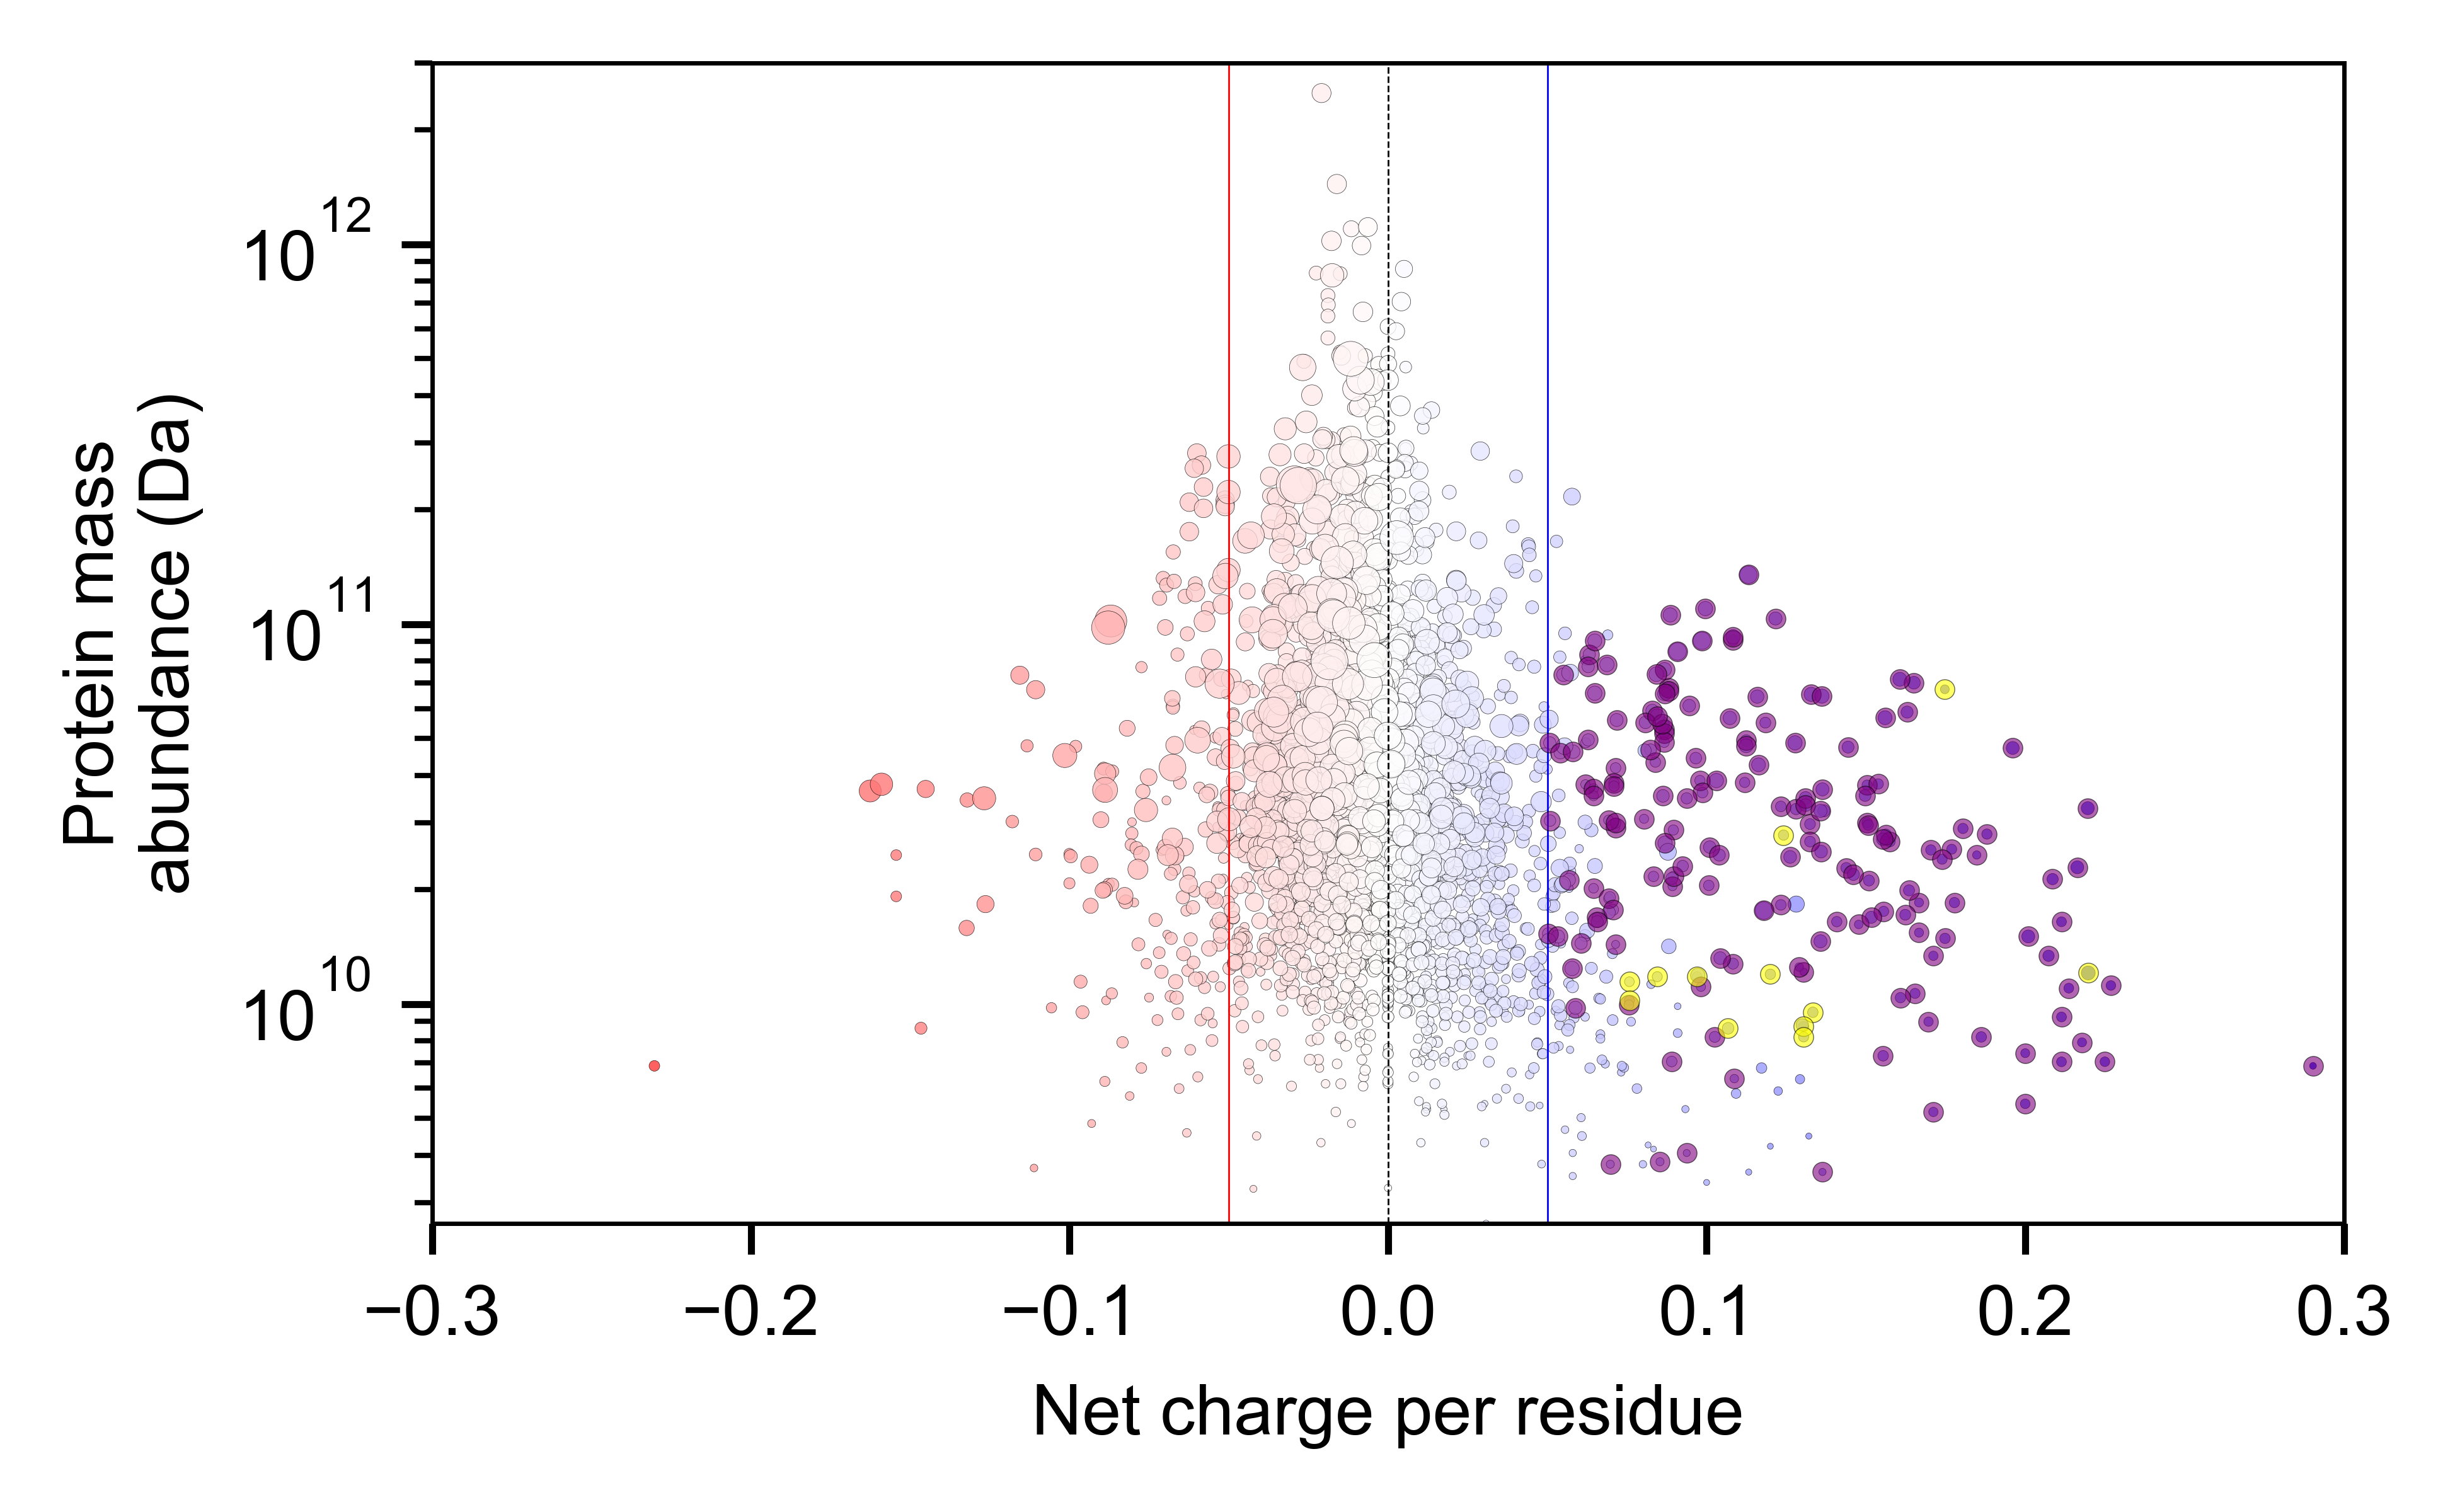

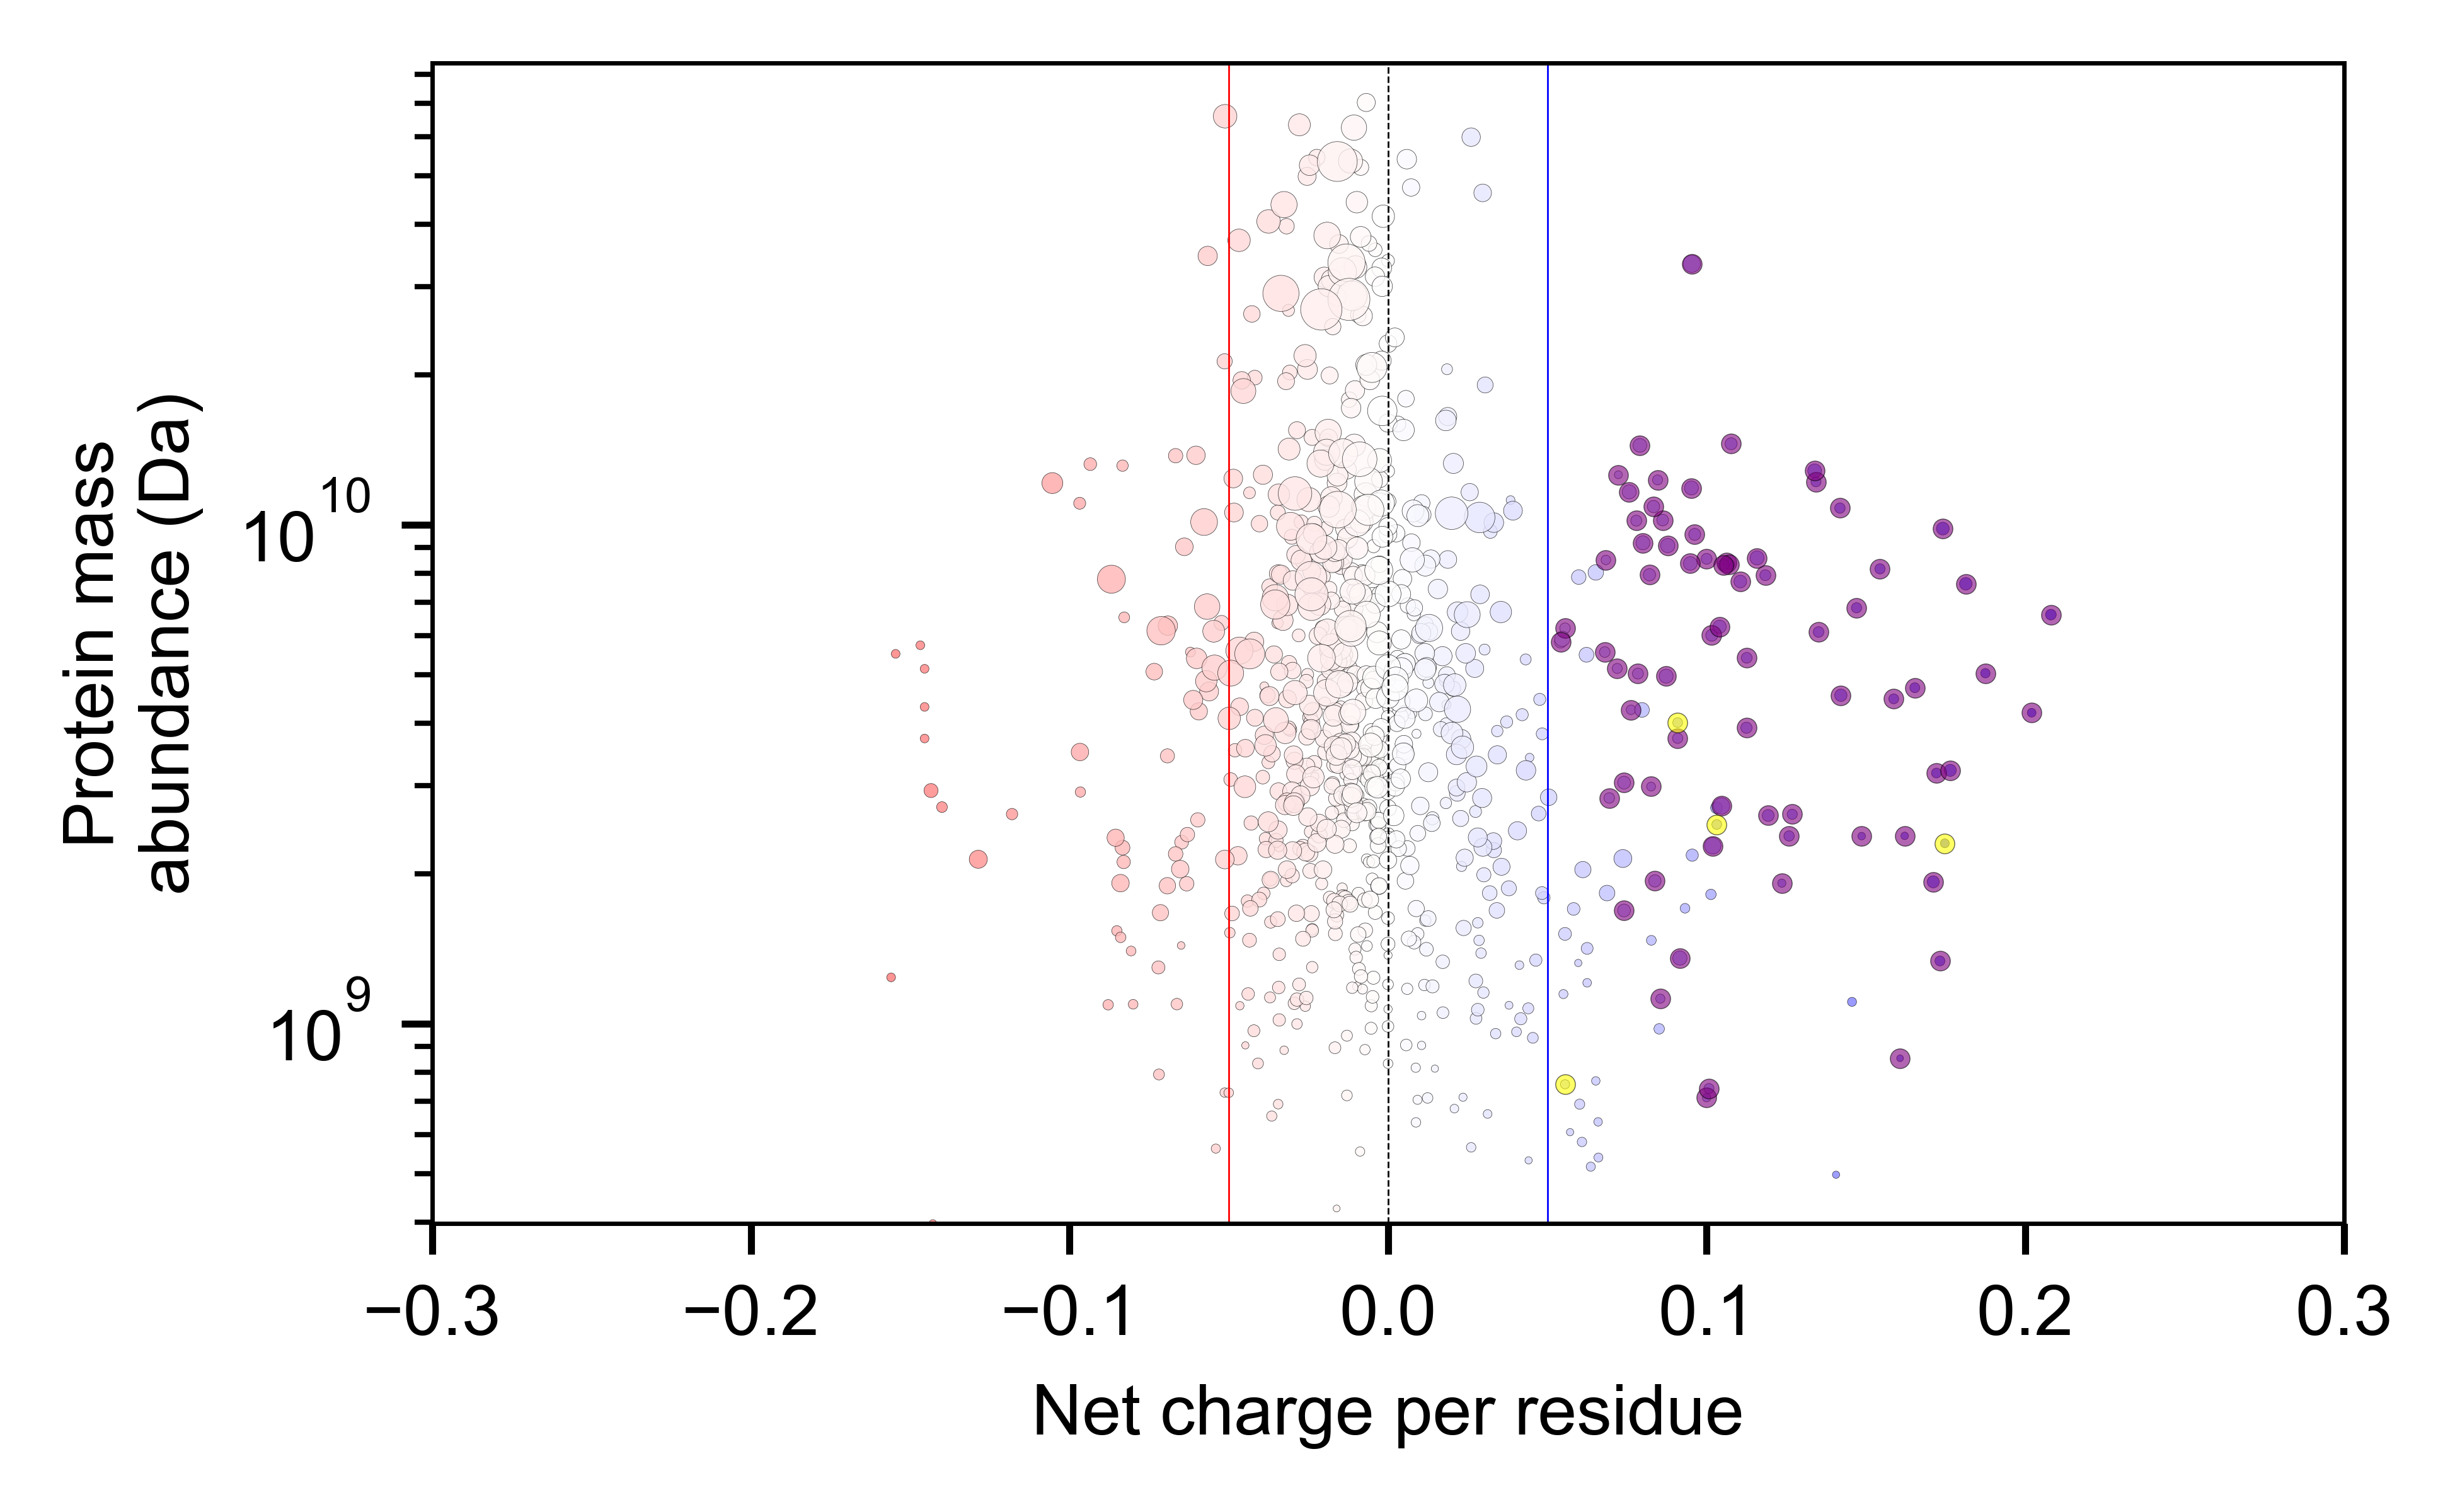

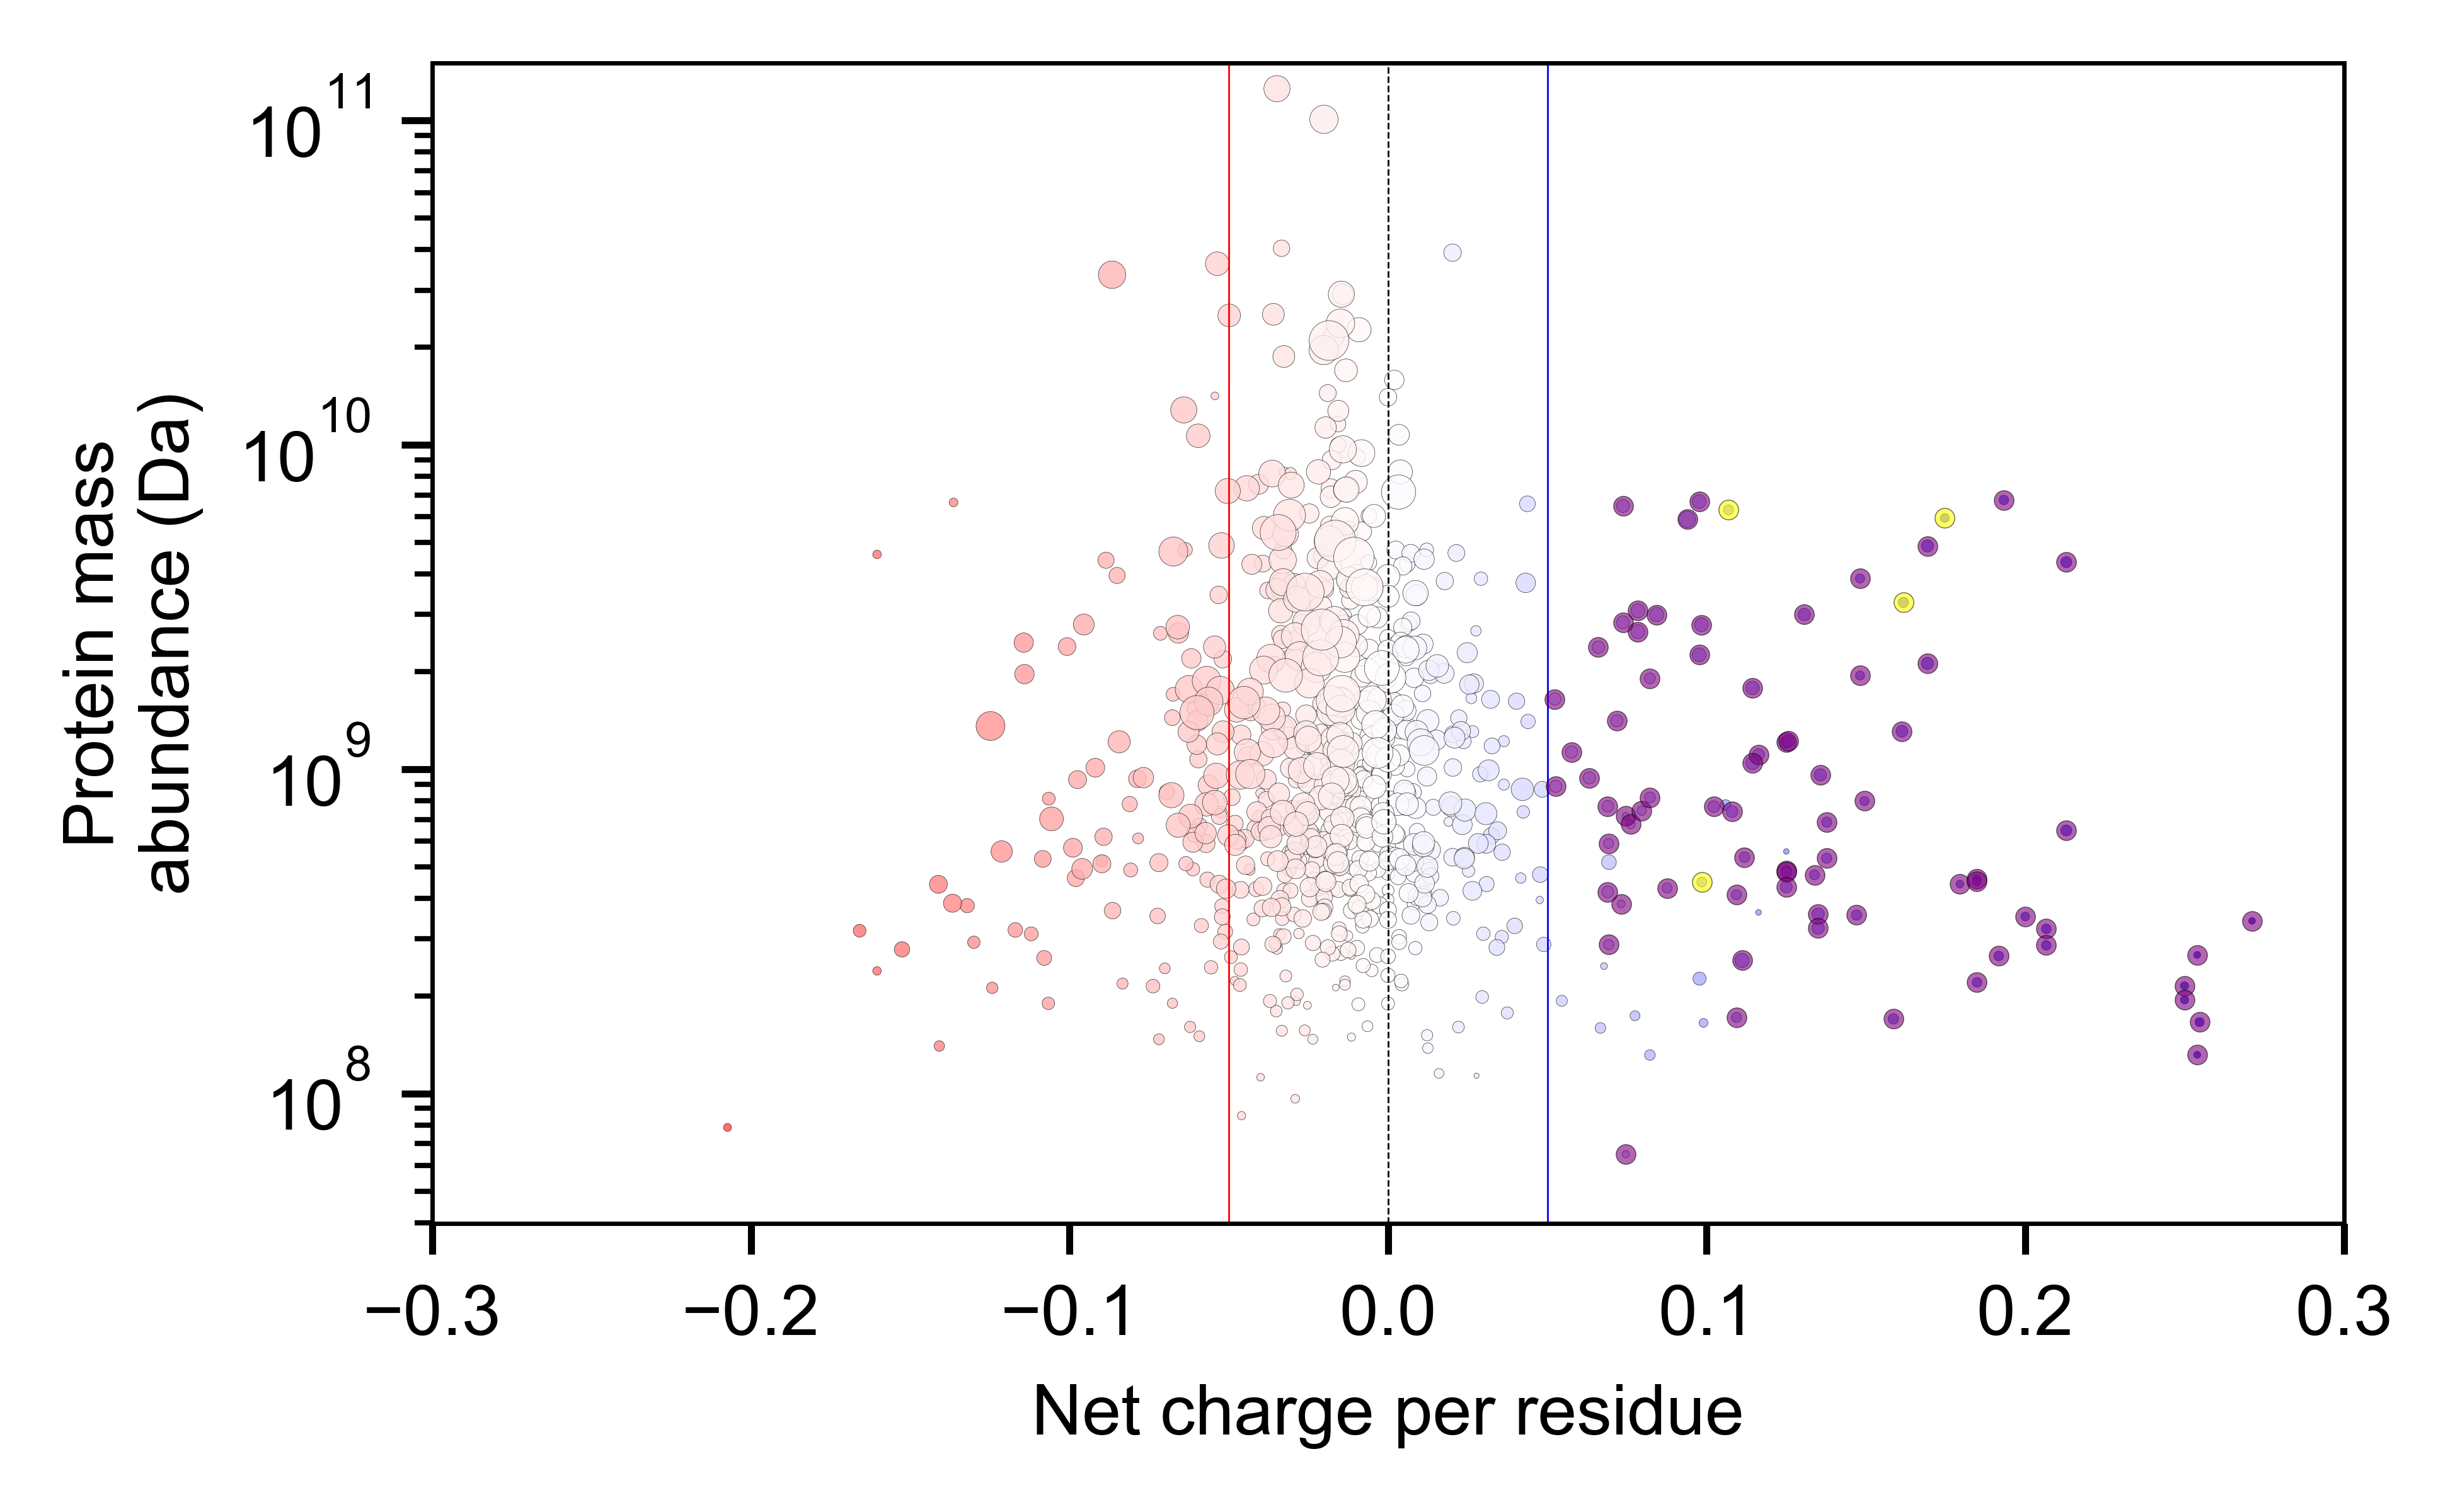

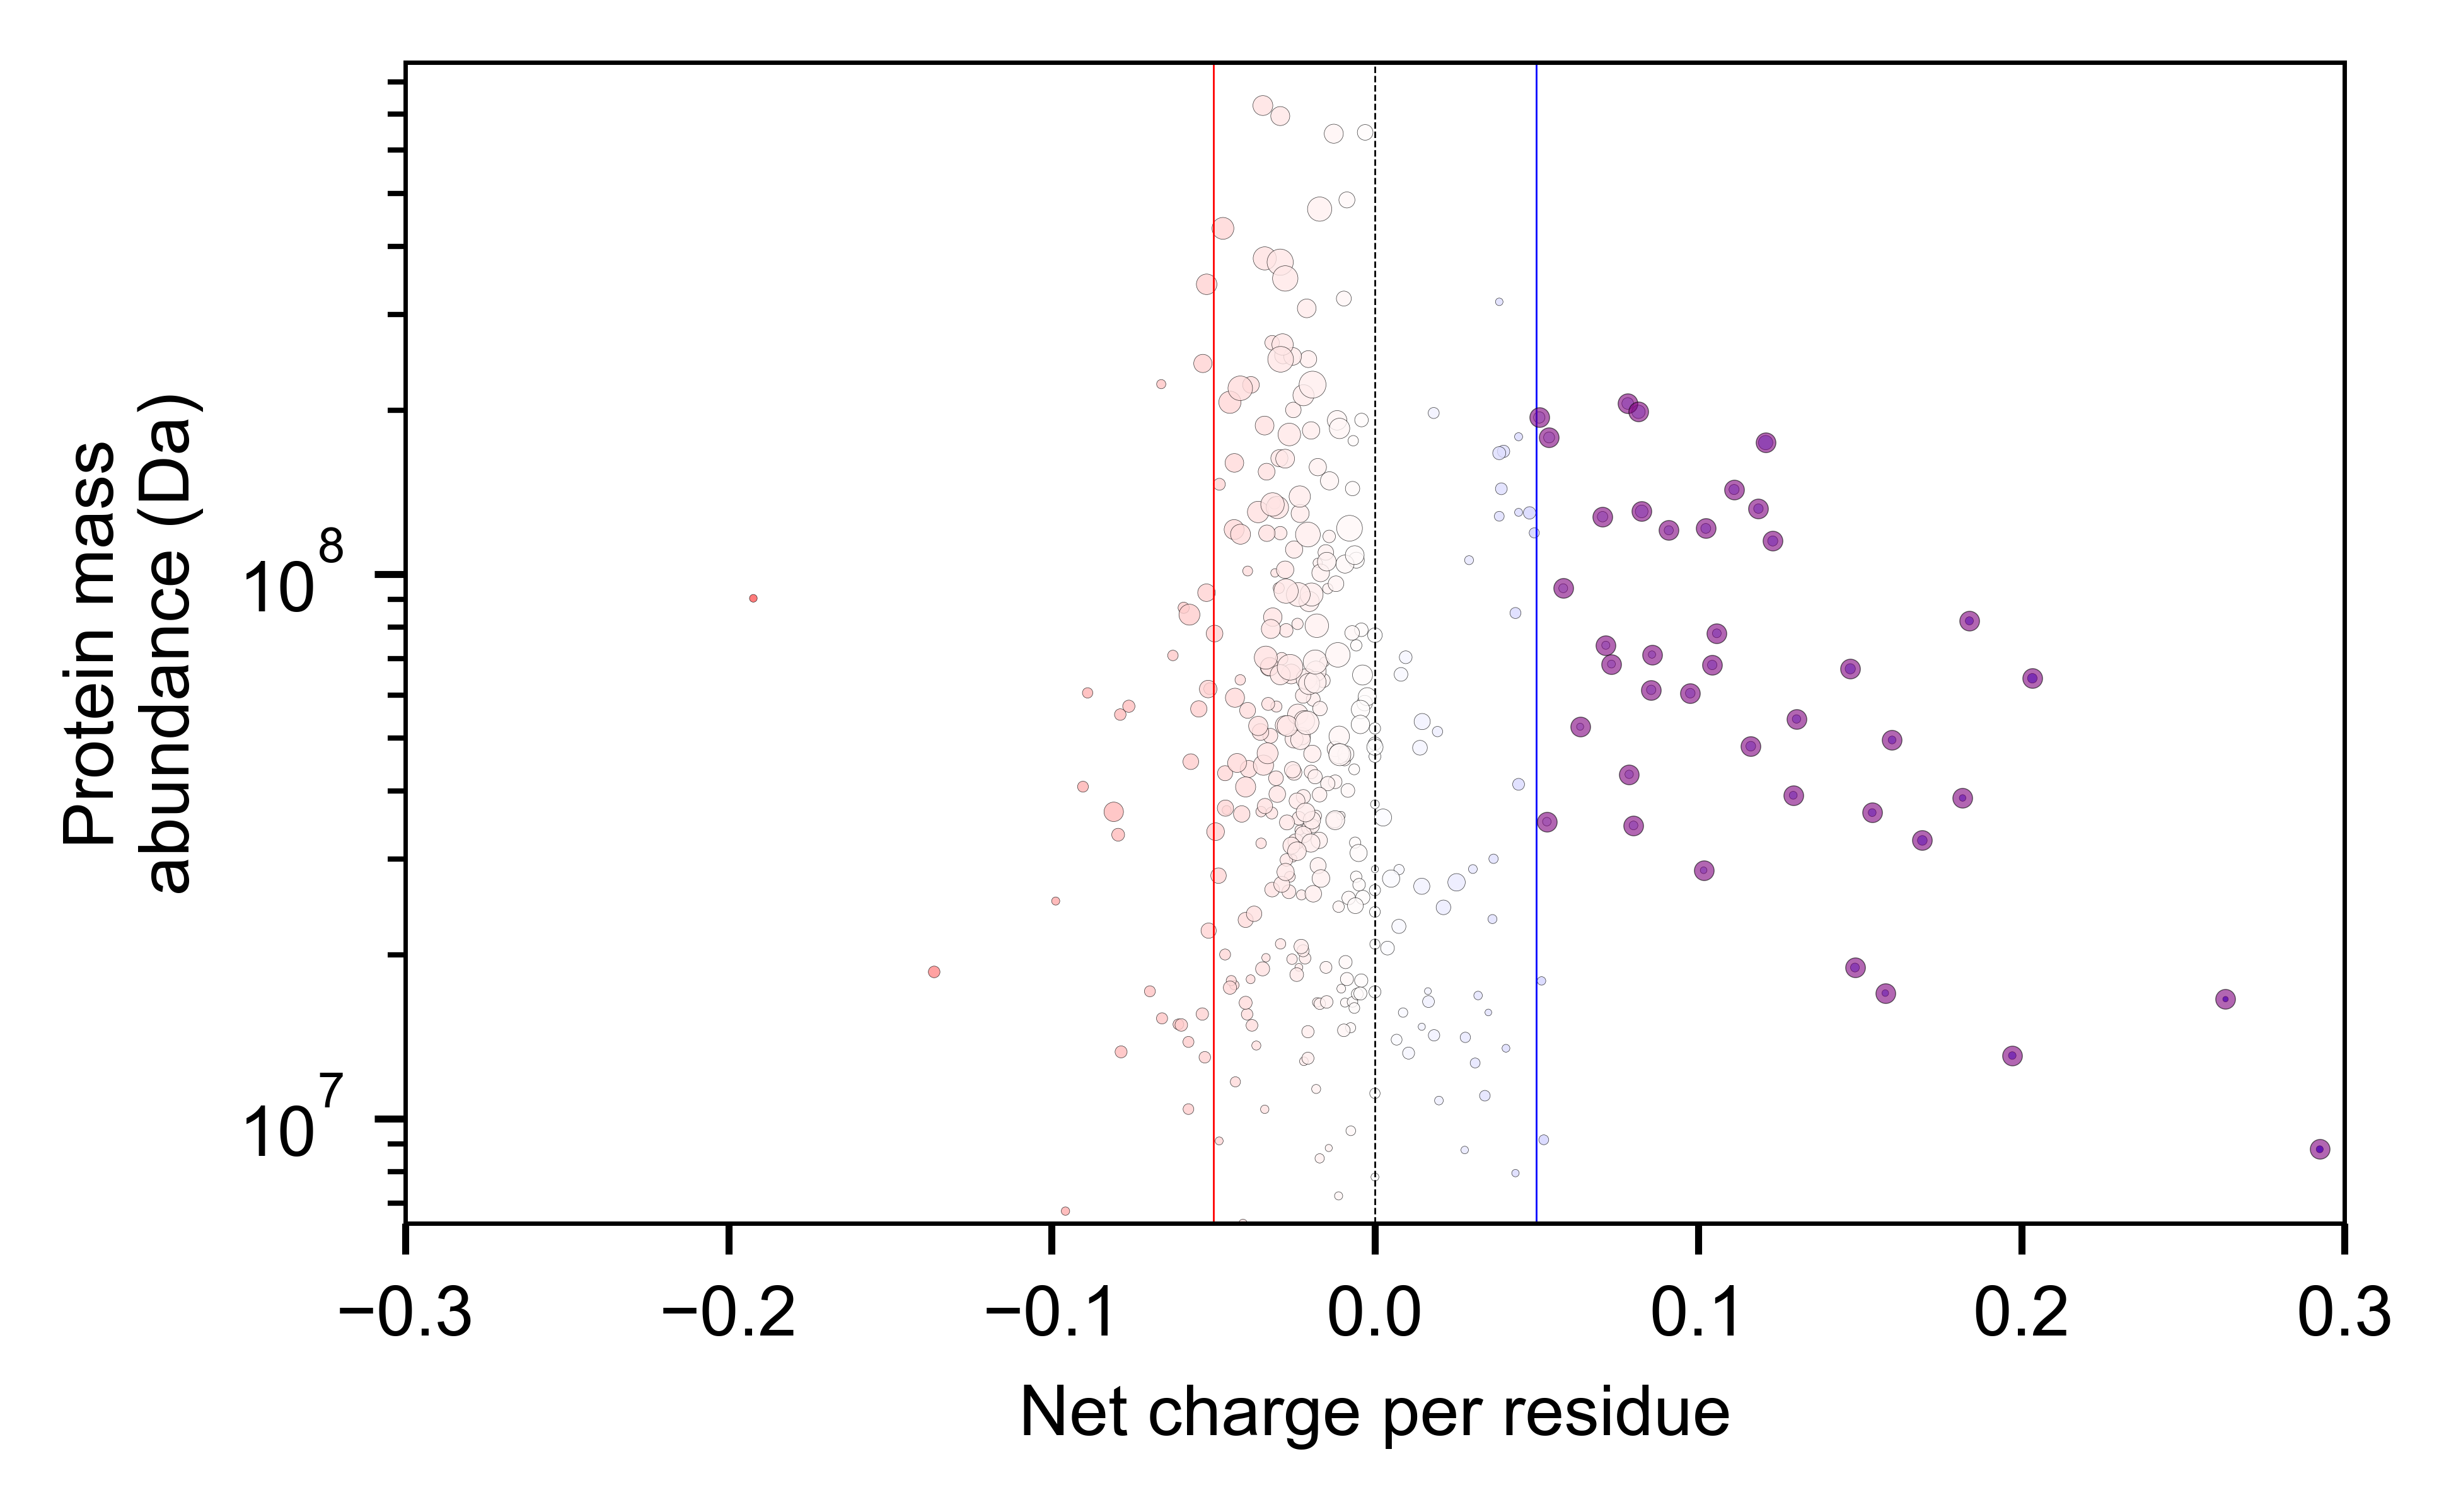

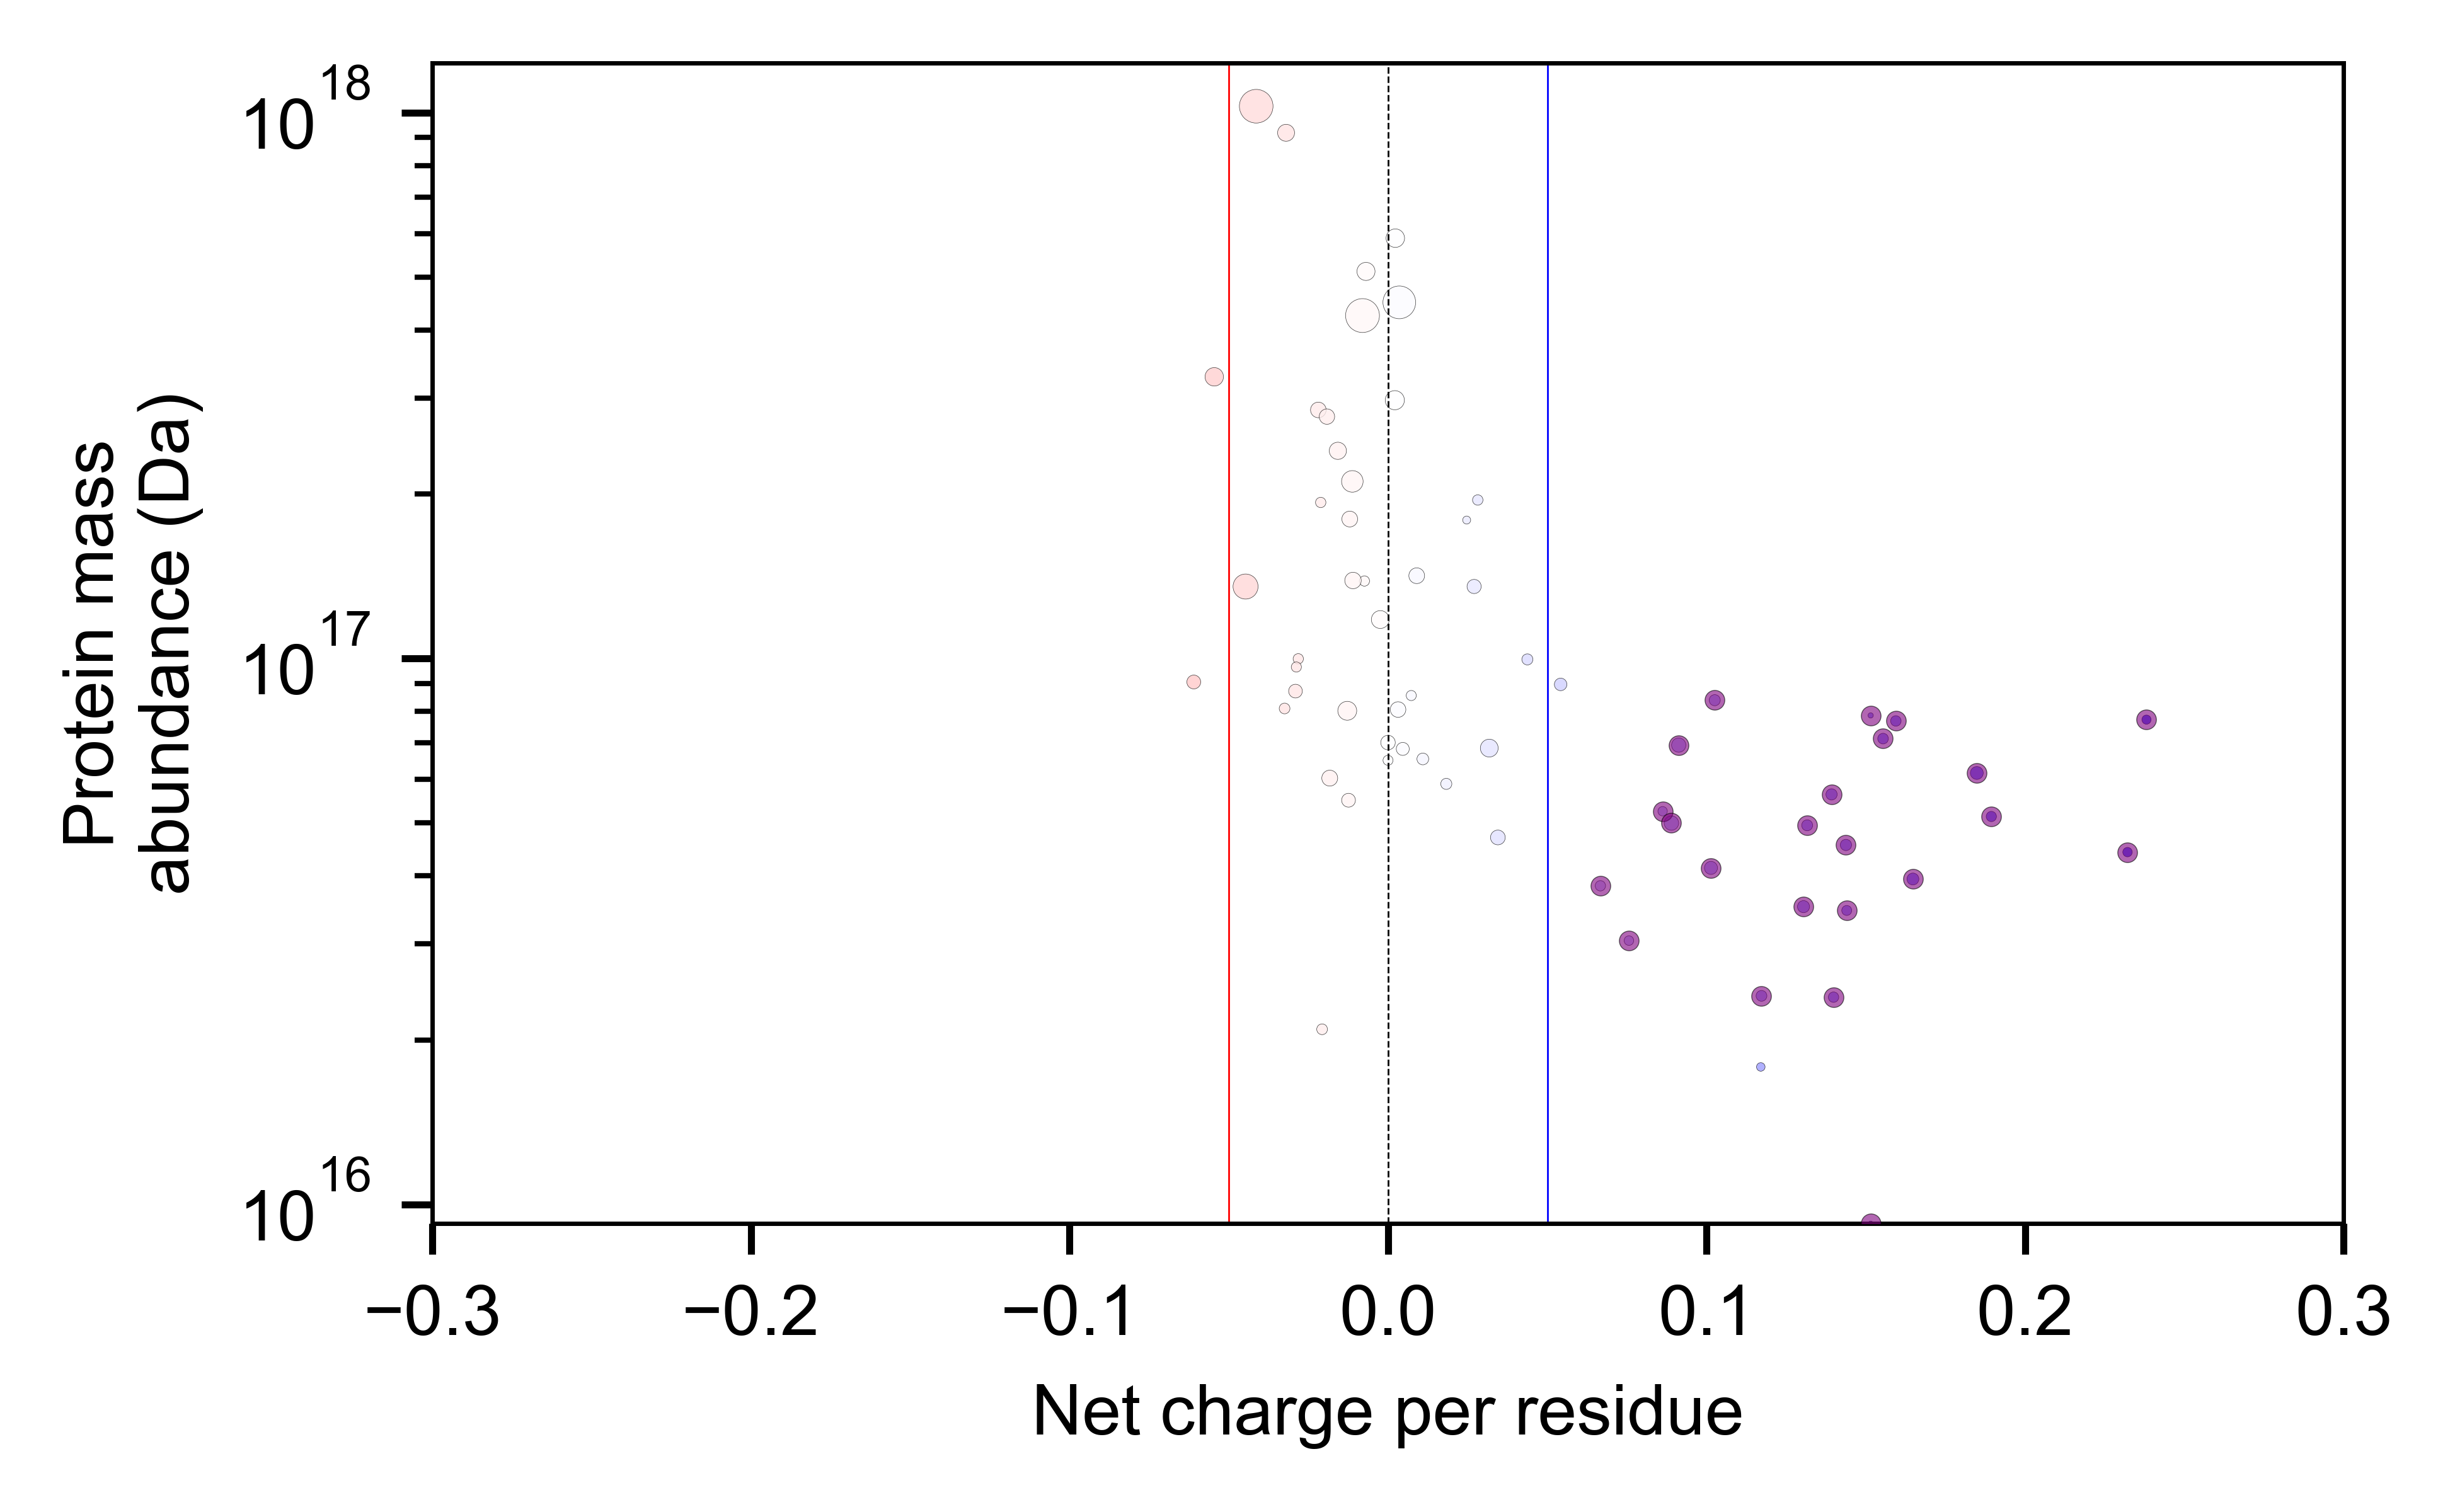

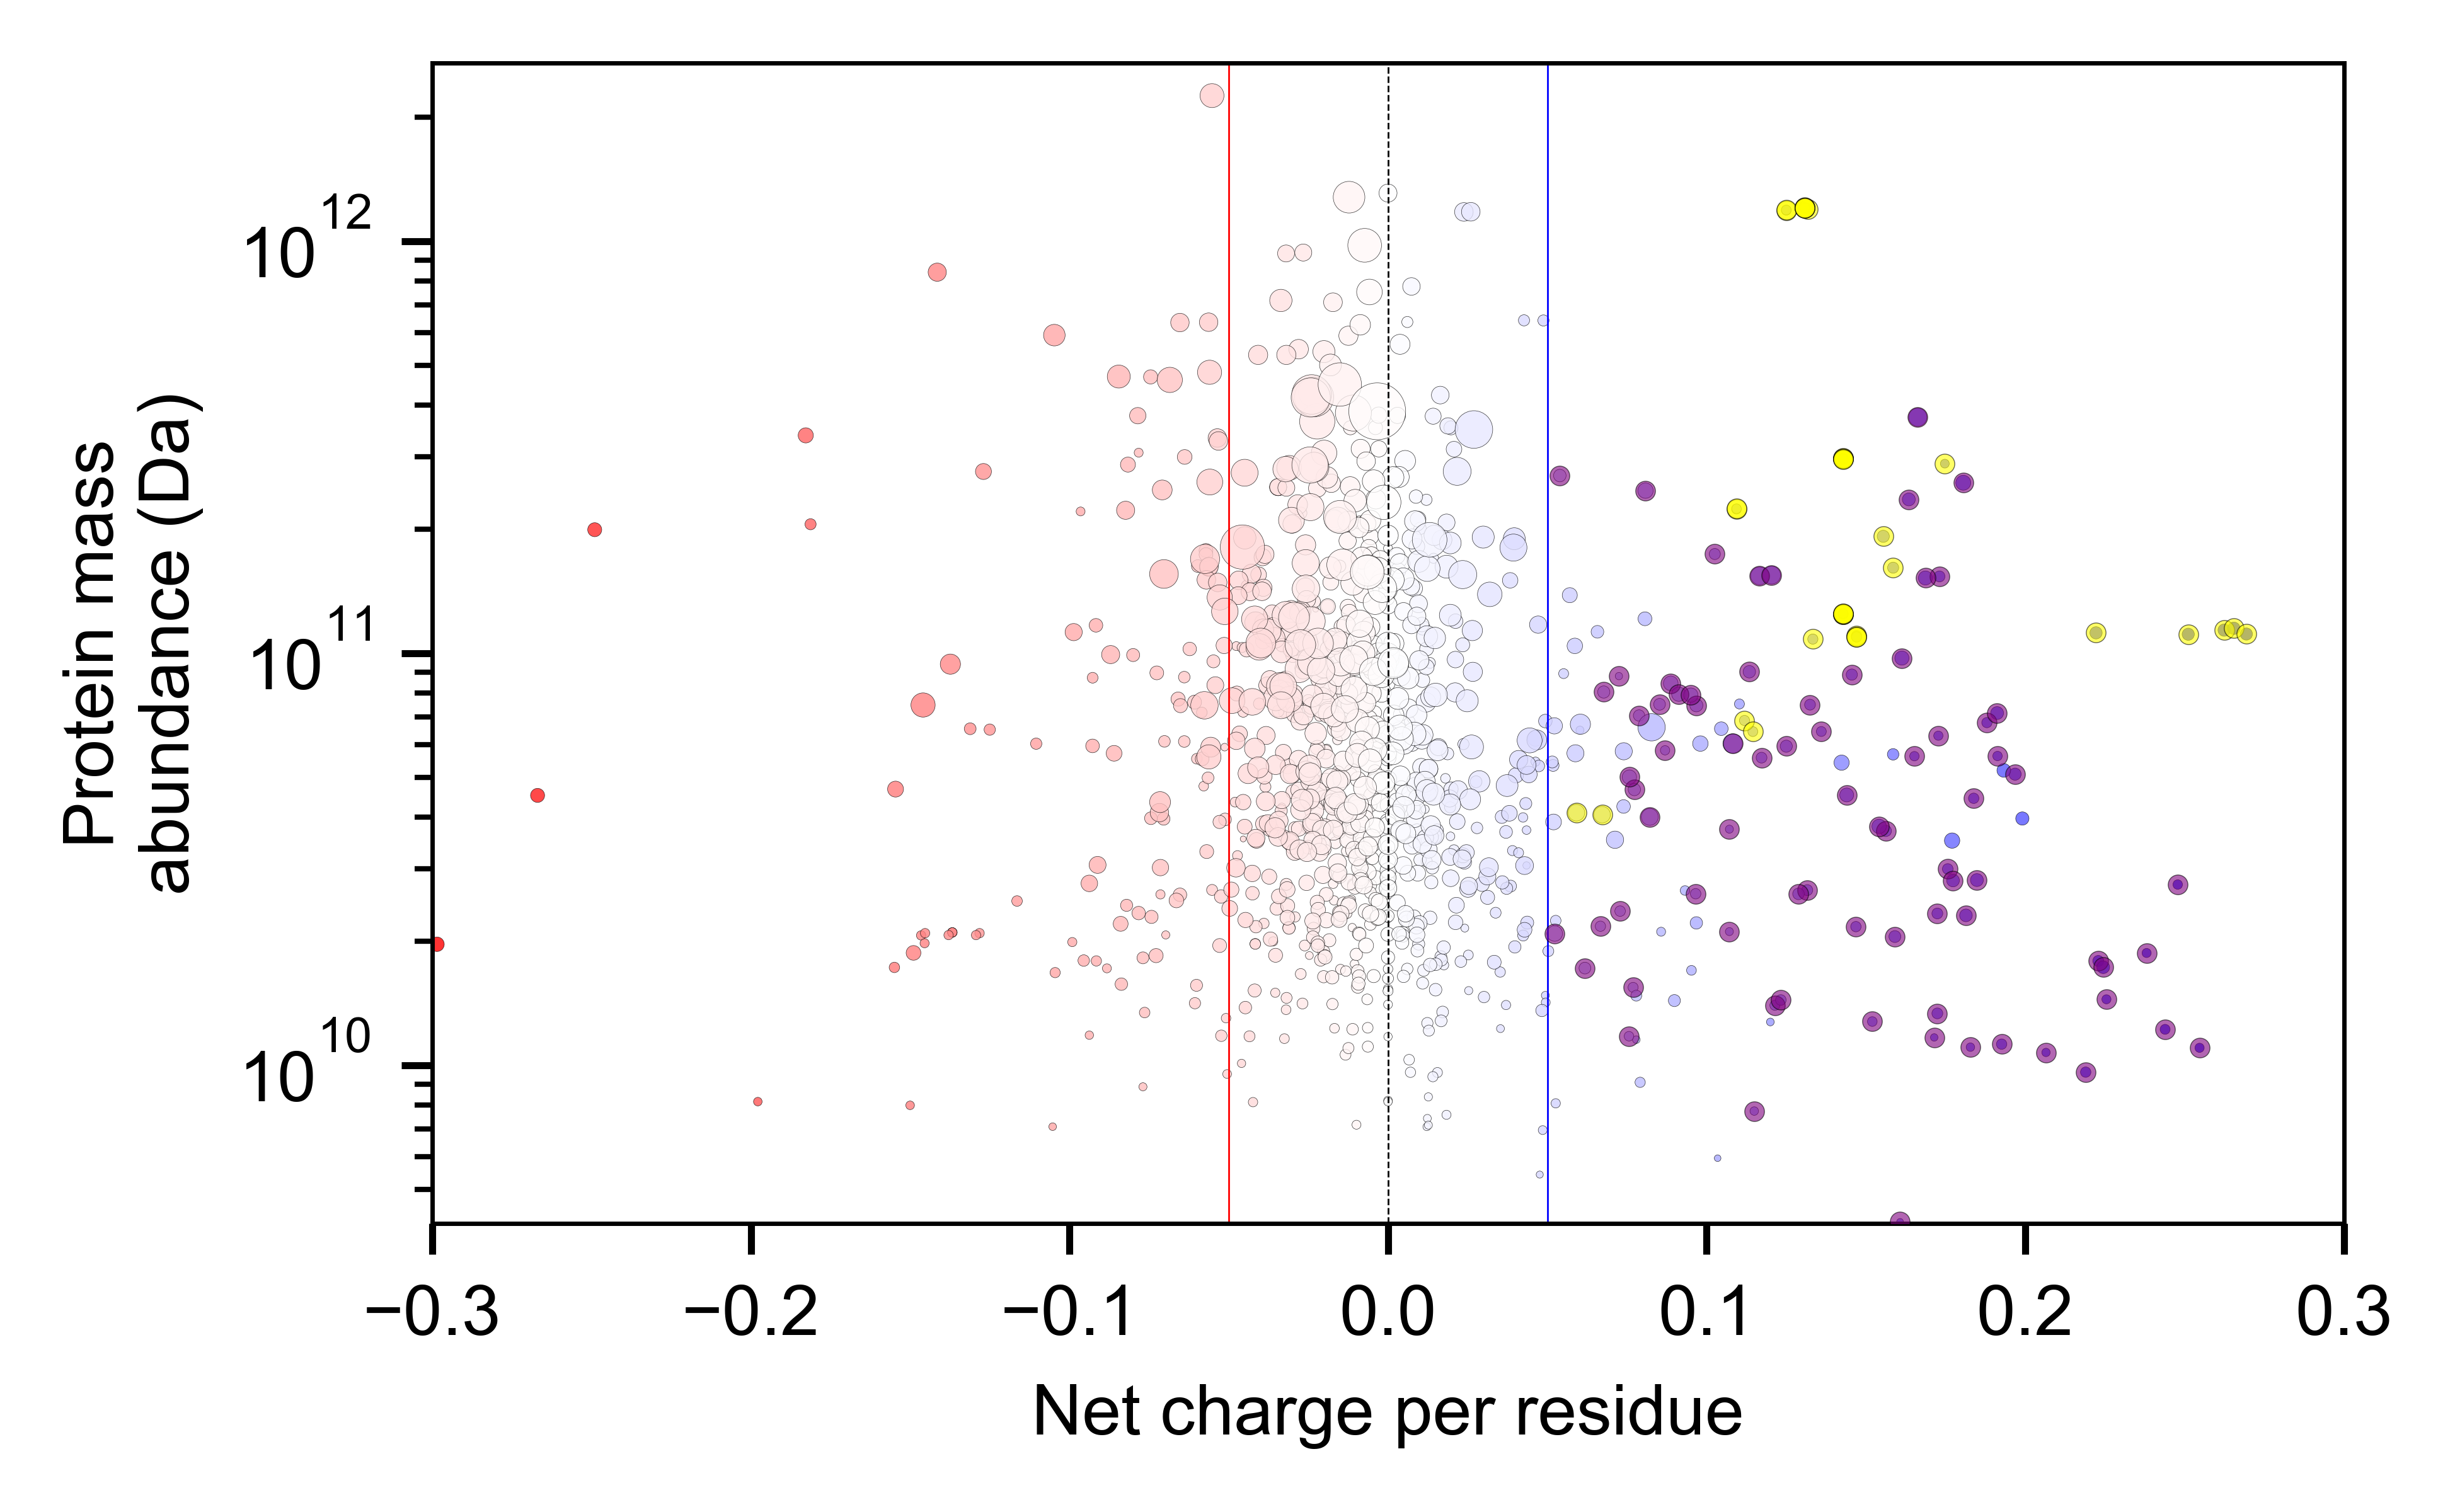

In [13]:
all_species_names = ['arabidopsis','pombe', 'yeast_ghaemmaghami', 'e_coli_wisniewski', 'xenopus', 'human']

# flag which, if set to true, means we label the histone and ribosomal proteins in
# the final figure
label_ribo_histone = False

# fraction of proteins we stop at (i.e. take top $max_fract protein) --> suggest using 0.85
max_fract = 0.85

# for each organism
for species_name in all_species_names:
    
    print(f'On {species_name}')
    
    ribosomal_protein_positions = []
    histone_positions = []

    # extract the proteome associated with this species and process out
    local_proteome = all_proteomes[species_name]
    [cn, ncpr, rd, rd_dict] = get_ncpr_vs_copynumber(local_proteome)

    # first figure out the index which we use to select the top max_fract of the proteins. Basically, the
    # loop below systematically takes the top $idx proteins and ask if that top $idx proteins makes up
    # over 0.85 of all proteins by copy number. Once it finds this he loop ends and idx is set
    for idx in range(0, len(rd.transpose()[0])):
        fract_of_prots = np.sum(rd.transpose()[0][:idx])/np.sum(rd.transpose()[0])
        if fract_of_prots > max_fract:
            break

    # sanity check print statement
    print(f"Index used: {idx}/{len(rd.transpose()[0])}")        

    # get all the accessions in the top max_fract set
    all_acc   = list(rd_dict.keys())[:idx]

    # all the counts (i.e. copy number) in the top max_fract set
    counts    = rd.transpose()[0][:idx]

    # all the vals (i.e. NCPR) in the top max_fract set
    vals      = rd.transpose()[1][:idx]

    # get protein molecular weight based on sequence for each protein in the top max_fract set
    prot_mass = [Protein(local_proteome.protein(i).sequence).molecular_weight for i in all_acc]

    # calculate mass * counts to give a total protein mass value (i.e. mass in Da of each protein)
    counts_times_mass = prot_mass*counts

    ##
    ## Make the figure
    ##

    figure(num=None, figsize=(4,2.5), dpi=500, facecolor='w', edgecolor='k')

    # Just converts protein mass to a reasonable sized circle with
    # a linear correction factor
    mass_scalar = 0.00009

    # define min/max NCPR (these must be symmetrical around 0) and define the xlim
    min_ncpr = -0.30
    max_ncpr = abs(min_ncpr)

    # plot the data 
    plt.scatter(vals, counts_times_mass, c=vals, s=np.array(prot_mass)*mass_scalar, cmap='bwr_r', vmin=min_ncpr, vmax=max_ncpr, edgecolor='k', linewidth=0.05, alpha=0.8)
    plt.yscale('log')
    plt.xlim(min_ncpr, max_ncpr)


    ncpr_thresh = 0.05
    positive_proteins = []
    annotations = []

    pos_total = 0
    for i in range(idx):    
        if vals[i] > ncpr_thresh:
            
            pos_total = pos_total + 1

            # get protein name - note we replace any commas with space so we can 
            # make a bona fide well-formatted CVS
            n = local_proteome.protein(all_acc[i]).name.replace(',', ' ')

            positive_proteins.append(local_proteome.protein(all_acc[i]))

            # if 'ribos' or 'hist' found in protein name
            if n.lower().find('ribos') > -1:
                annotations.append('ribosomal protein')
                if label_ribo_histone:
                    ribosomal_protein_positions.append([vals[i], counts_times_mass[i]])
                    
            elif n.lower().find('hist') > -1:
                if label_ribo_histone:
                    histone_positions.append([vals[i], counts_times_mass[i]])

                annotations.append('histone protein')
            else:
                annotations.append('misc.')


    # check for negative proteins as well        
    neg_total = 0            
    for i in range(idx):    
        if vals[i] < -ncpr_thresh:
            neg_total = neg_total + 1


    ymin = min(counts_times_mass)
    ymax = max(counts_times_mass)*1.2

    plt.plot([ncpr_thresh,ncpr_thresh], [ymin, ymax],'-b',linewidth=0.2)
    plt.plot([-ncpr_thresh, -ncpr_thresh], [ymin, ymax],'-r',linewidth=0.2)

    plt.plot([0,0], [ymin, ymax],'--k',linewidth=0.2)            
    plt.ylim([ymin,ymax])


    #ax = plt.gca()
    #ax.axvspan(ncpr_thresh, 0.25, color='b', linewidth=0, alpha=0.01, zorder=-20)
    #ax.axvspan(-ncpr_thresh, -0.25, color='r', linewidth=0, alpha=0.01, zorder=-20)

    ribo_count = annotations.count('ribosomal protein')
    hist_count = annotations.count('histone protein')

    print(f'Positive fraction: {round(pos_total/idx,3)}')
    print(f'Negative fraction: {round(neg_total/idx,3)}')
    print(f'Positive count: {round(pos_total,3)}')
    print(f'Negative count: {round(neg_total,3)}')
    
    print(f'Fraction ribosomal proteins: {round(ribo_count/pos_total,4)}')
    print(f'Fraction histone proteins  : {round(hist_count/pos_total,4)}')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylabel('Protein mass\nabundance (Da)', fontsize=8)
    plt.xlabel('Net charge per residue', fontsize=8)
    plt.tight_layout()

    # save proteins to csv
    write_protein_info_to_csv(f'data_out/{species_name}_positive_proteins.csv', positive_proteins, annotations)
    
    if label_ribo_histone:
        for i in ribosomal_protein_positions:
            plt.plot(i[0],i[1],'.', ms=4.5, mew=0.1, color='purple', zorder=30,mec='k', alpha=0.6)
        for i in histone_positions:
            plt.plot(i[0],i[1],'.', ms=4.5, mew=0.1, color='yellow', zorder=30,mec='k', alpha=0.6)
    
    if label_ribo_histone:
        plt.savefig(f'figures/{species_name}_full_figure_histo_ribo_label_{str(max_fract)[2:]}.pdf')
        plt.savefig(f'figures/{species_name}_full_figure_histo_ribo_label_{str(max_fract)[2:]}.png', dpi=450)
    else:
        plt.savefig(f'figures/{species_name}_full_figure.pdf')
        plt.savefig(f'.figures{species_name}_full_figure.png', dpi=450)


        
 

In [17]:
local_cn = []
for x in rd_dict:
    local_cn.append(rd_dict[x][0])
    
local_idx = np.arange(1,len(local_cn)+1)
    

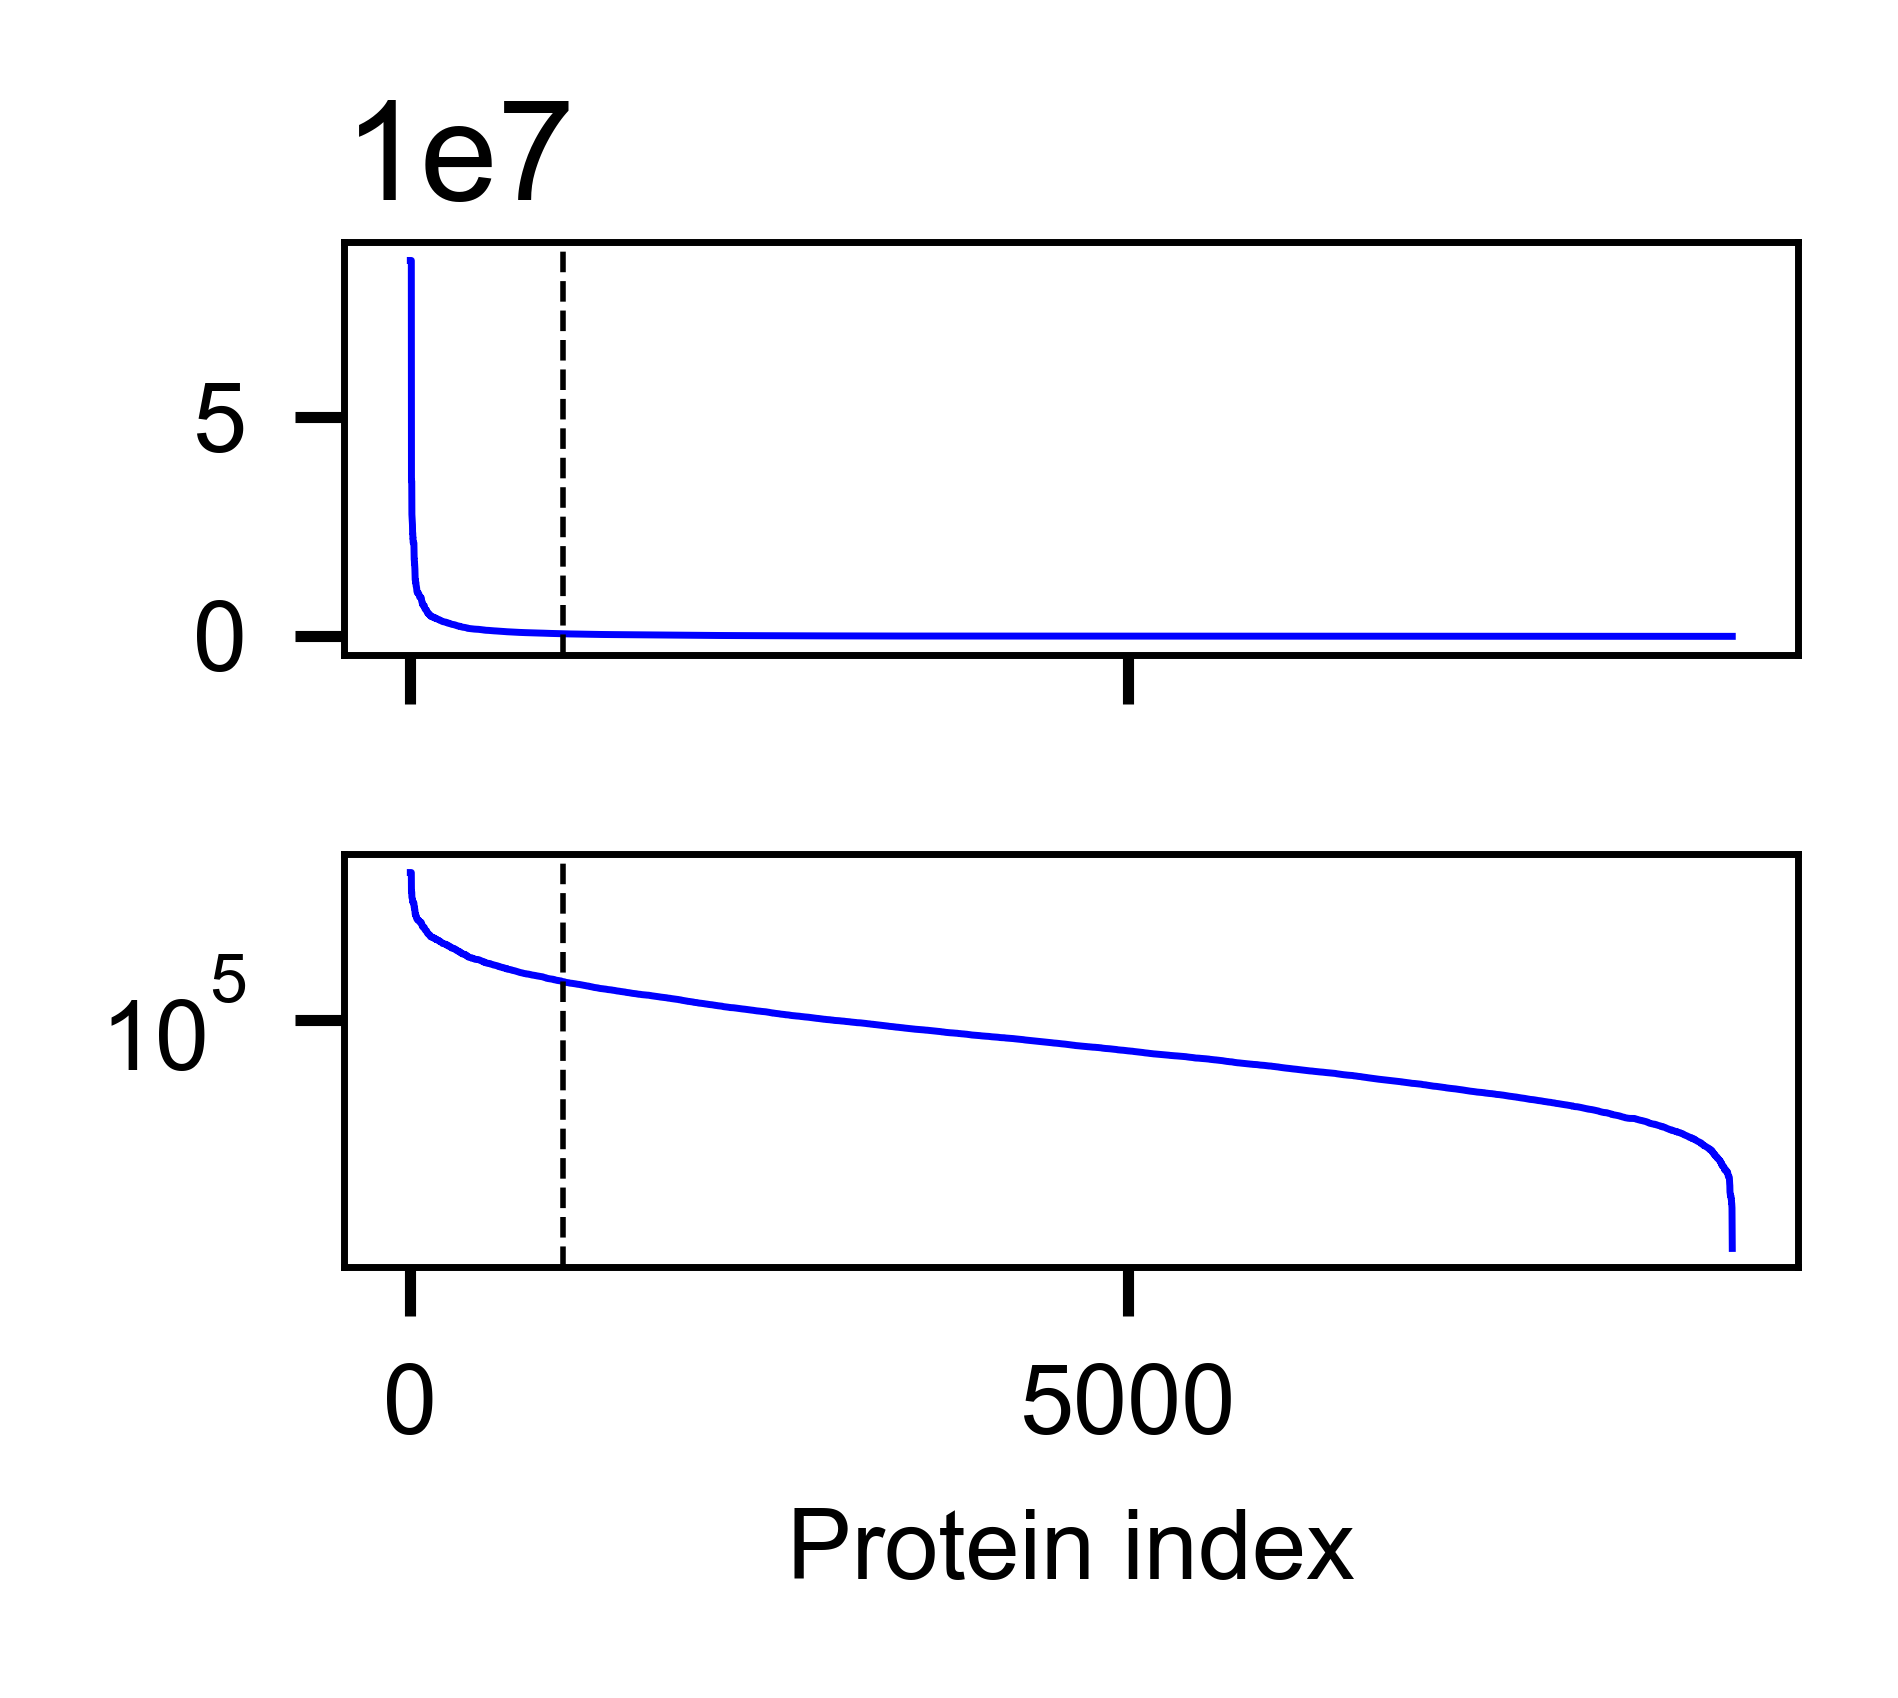

In [18]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(2,1.8), dpi=500, facecolor='w', edgecolor='k')

ax[0].plot(local_idx, local_cn, color='b', linewidth=0.5)
ax[1].plot(local_idx, local_cn, color='b', linewidth=0.5)
ax[1].set_yscale('log')


ax[1].tick_params(axis='x',labelsize=7)
ax[1].tick_params(axis='y',labelsize=7)
ax[1].set_xlabel('Protein index', fontsize=7)

ax[0].tick_params(axis='y',labelsize=7)

ax[0].axvline(idx,color='k',linestyle='--', linewidth=0.4)
ax[1].axvline(idx,color='k',linestyle='--', linewidth=0.4)
plt.tight_layout()
plt.savefig('figures/top_85.pdf')
